# HONDA Cars Web Scraping – AckoDrive

This notebook scrapes Honda car data from AckoDrive, cleans it, and exports it to a CSV file.

**Steps covered:**
1. Research & planning (URL and basic structure)
2. Data extraction with BeautifulSoup
3. Data cleaning & preprocessing
4. Data presentation/export to CSV


In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import datetime

## 1. Fetch Honda cars page

In [4]:
BASE_URL = "https://ackodrive.com"
HONDA_URL = f"{BASE_URL}/collection/honda+cars/"

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/123.0.0.0 Safari/537.36"
    ),
    "Accept-Language": "en-US,en;q=0.9",
}

response = requests.get(HONDA_URL, headers=HEADERS)
print("Status code:", response.status_code)
html = response.text


Status code: 200


## 2. Parse HTML with BeautifulSoup

In [7]:
soup = BeautifulSoup(html, "html.parser")
print(soup.title.string if soup.title else "No title found")

Honda Cars Price in India - Honda Car Models in 2025


## 3. Extract Honda car details

We extract model name, variants, fuel information, transmission, and price. Selectors are based on the current structure of the Honda collection page. If AckoDrive changes their HTML, you may need to adjust the CSS selectors accordingly using browser *Inspect*.

In [8]:
def extract_honda_cards(soup: BeautifulSoup):
    cards_data = []
    main_heading = soup.find(string=re.compile(r"Honda cars in India", re.I))
    if main_heading:
        # Move up to a reasonably large container
        container = main_heading.find_parent()
        for _ in range(4):  # climb up a few levels defensively
            if container and container.parent:
                container = container.parent
    else:
        container = soup
    model_links = []
    for a in container.find_all("a", href=True):
        text = a.get_text(strip=True)
        if text.startswith("Honda "):
            model_links.append(a)

    print(f"Found {len(model_links)} Honda model entries")

    for a in model_links:
        model_name = a.get_text(strip=True)
        brand = "Honda"
        detail_href = a["href"]
        detail_url = detail_href if detail_href.startswith("http") else BASE_URL + detail_href
        block_texts = []
        parent_block = a.parent
        for sib in parent_block.next_siblings:
            if getattr(sib, "name", None) is None:
                continue
            txt = sib.get_text(" ", strip=True)
            if not txt:
                continue
            block_texts.append(txt)
            if "Browse Honda cars" in txt or "Home" == txt:
                break

        full_block = " \n ".join(block_texts)

        variants_match = re.search(r"(\d+\s+Variants)", full_block, flags=re.I)
        variants = variants_match.group(1) if variants_match else "N/A"

        fuel_match = re.search(r"(Hybrid[^\n]*|Petrol[^\n]*|Diesel[^\n]*Electric[^\n]*)", full_block, flags=re.I)
        fuel = fuel_match.group(1).strip() if fuel_match else "N/A"

        trans_match = re.search(r"(Manual\s*•\s*Automatic|Manual|Automatic)", full_block, flags=re.I)
        transmission = trans_match.group(1).strip() if trans_match else "N/A"

        price_match = re.search(r"₹[^\n]*lakh[^\n]*", full_block)
        price_range = price_match.group(0).strip() if price_match else "N/A"

        is_discontinued = bool(re.search(r"Discontinued", full_block, flags=re.I))

        cards_data.append({
            "brand": brand,
            "model": model_name,
            "variants": variants,
            "fuel": fuel,
            "transmission": transmission,
            "price_range_raw": price_range,
            "is_discontinued": is_discontinued,
            "detail_url": detail_url,
        })

    return cards_data

In [9]:
cards_data = extract_honda_cards(soup)
len(cards_data), cards_data[:3]

Found 7 Honda model entries


(7,
 [{'brand': 'Honda',
   'model': 'Honda City',
   'variants': 'N/A',
   'fuel': 'Hybrid • Petrol Manual • Automatic',
   'transmission': 'Manual • Automatic',
   'price_range_raw': 'N/A',
   'is_discontinued': False,
   'detail_url': 'https://ackodrive.com/cars/honda-city/'},
  {'brand': 'Honda',
   'model': 'Honda Elevate',
   'variants': 'N/A',
   'fuel': 'Petrol • Manual • Automatic',
   'transmission': 'Manual • Automatic',
   'price_range_raw': 'N/A',
   'is_discontinued': False,
   'detail_url': 'https://ackodrive.com/cars/honda-elevate/'},
  {'brand': 'Honda',
   'model': 'Honda Amaze',
   'variants': 'N/A',
   'fuel': 'Petrol Manual • Automatic',
   'transmission': 'Manual • Automatic',
   'price_range_raw': 'N/A',
   'is_discontinued': False,
   'detail_url': 'https://ackodrive.com/cars/honda-amaze/'}])

## 4. Create DataFrame

In [12]:
df_raw = pd.DataFrame(cards_data)
df_raw

,brand,model,variants,fuel,transmission,price_range_raw,is_discontinued,detail_url
0,Honda,Honda City,N/A,Hybrid • Petrol Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-city/
1,Honda,Honda Elevate,N/A,Petrol • Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-elevate/
2,Honda,Honda Amaze,N/A,Petrol Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-amaze/
3,Honda,Honda Amaze (2021-2024),N/A,Petrol Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-amaze-2021-2024/
4,Honda,Honda WR-V (2020-2023),N/A,Petrol • Diesel Manual,Manual,N/A,False,https://ackodrive.com/cars/honda-wr-v-2020-2023/
5,Honda,Honda Jazz (2020-2023),N/A,Petrol Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-jazz-2020-2023/
6,Honda,Honda City (2020-2023),N/A,Hybrid • Petrol • Diesel Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-city-2020-2023/


In [16]:
df.to_csv("honda_cars.csv", index=False, encoding="utf-8-sig")

## 5. Data Cleaning

- Normalize column names
- Extract numeric min/max prices from the price range string
- Add scrape date

In [17]:
df = df_raw.copy()

df["scrape_date"] = datetime.today().date()

def parse_price_range(price_str: str):
    """Parse a price range like '₹13.9 lakh – ₹23.9 lakh' into numeric min/max (in lakh)."""
    if not isinstance(price_str, str) or "₹" not in price_str:
        return None, None
    cleaned = price_str.replace("–", "-")
    nums = re.findall(r"\d+\.\d+|\d+", cleaned)
    if not nums:
        return None, None
    nums = [float(n) for n in nums]
    if len(nums) == 1:
        return nums[0], nums[0]
    return min(nums), max(nums)

df["price_min_lakh"], df["price_max_lakh"] = zip(*df["price_range_raw"].map(parse_price_range))

df

,brand,model,variants,fuel,transmission,price_range_raw,is_discontinued,detail_url,scrape_date,price_min_lakh,price_max_lakh
0,Honda,Honda City,N/A,Hybrid • Petrol Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-city/,2025-12-07,None,None
1,Honda,Honda Elevate,N/A,Petrol • Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-elevate/,2025-12-07,None,None
2,Honda,Honda Amaze,N/A,Petrol Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-amaze/,2025-12-07,None,None
3,Honda,Honda Amaze (2021-2024),N/A,Petrol Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-amaze-2021-2024/,2025-12-07,None,None
4,Honda,Honda WR-V (2020-2023),N/A,Petrol • Diesel Manual,Manual,N/A,False,https://ackodrive.com/cars/honda-wr-v-2020-2023/,2025-12-07,None,None
5,Honda,Honda Jazz (2020-2023),N/A,Petrol Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-jazz-2020-2023/,2025-12-07,None,None
6,Honda,Honda City (2020-2023),N/A,Hybrid • Petrol • Diesel Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-city-2020-2023/,2025-12-07,None,None


## 6. Export to CSV

In [18]:
output_path = "honda_ackodrive_cars.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"Saved {len(df)} rows to {output_path}")

Saved 7 rows to honda_ackodrive_cars.csv


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set(font_scale=1.2)

In [22]:
# View first rows
df.head()

# Shape
print("Rows:", df.shape[0], " Columns:", df.shape[1])

# Info
df.info()

# Missing values
df.isnull().sum()

# Numerical summary
df.describe()

Rows: 7  Columns: 11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   brand            7 non-null      object
 1   model            7 non-null      object
 2   variants         7 non-null      object
 3   fuel             7 non-null      object
 4   transmission     7 non-null      object
 5   price_range_raw  7 non-null      object
 6   is_discontinued  7 non-null      bool  
 7   detail_url       7 non-null      object
 8   scrape_date      7 non-null      object
 9   price_min_lakh   0 non-null      object
 10  price_max_lakh   0 non-null      object
dtypes: bool(1), object(10)
memory usage: 699.0+ bytes


,brand,model,variants,fuel,transmission,price_range_raw,is_discontinued,detail_url,scrape_date,price_min_lakh,price_max_lakh
count,7,7,7,7,7,7,7,7,7,0,0
unique,1,7,1,5,2,1,1,7,1,0,0
top,Honda,Honda City,N/A,Petrol Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-city/,2025-12-07,NaN,NaN
freq,7,1,7,3,6,7,7,1,7,NaN,NaN


In [23]:
duplicate_count = df.duplicated().sum()
print("Duplicate rows:", duplicate_count)

if duplicate_count > 0:
    df = df.drop_duplicates()

Duplicate rows: 0


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,5)

# Auto-detect possible numeric columns
price_cols = [c for c in df.columns if "price" in c.lower()]
km_cols    = [c for c in df.columns if "km" in c.lower()]
year_cols  = [c for c in df.columns if "year" in c.lower()]

fuel_col   = next((c for c in df.columns if "fuel" in c.lower()), None)
trans_col  = next((c for c in df.columns if "trans" in c.lower()), None)

print("Detected Columns:")
print("Price columns:", price_cols)
print("KM columns:", km_cols)
print("Year columns:", year_cols)
print("Fuel:", fuel_col)
print("Transmission:", trans_col)

Detected Columns:
Price columns: ['price_range_raw', 'price_min_lakh', 'price_max_lakh']
KM columns: []
Year columns: []
Fuel: fuel
Transmission: transmission


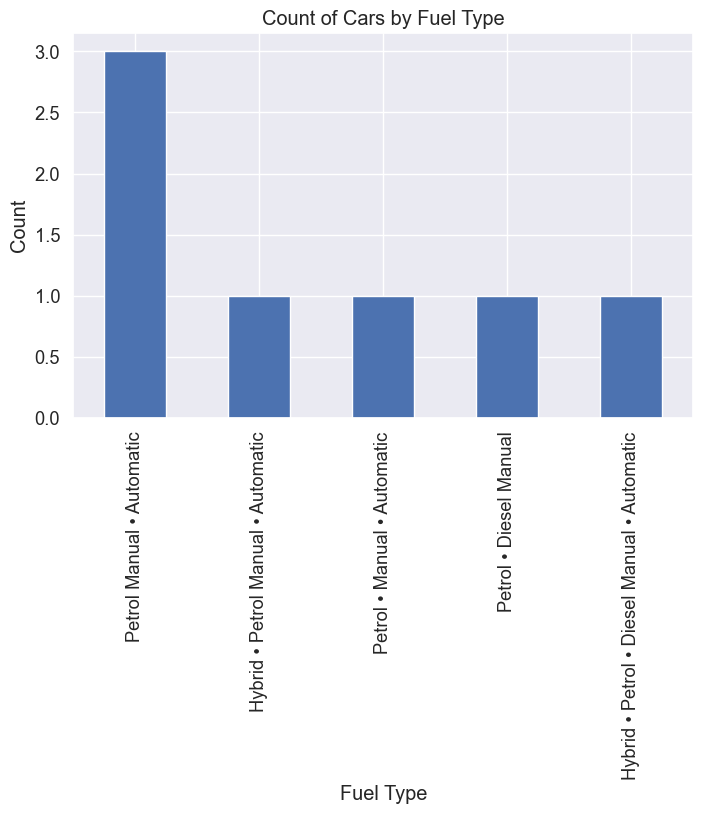

In [26]:
plt.figure(figsize=(8,5))
df['fuel'].value_counts().plot(kind='bar')
plt.title("Count of Cars by Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Count")
plt.show()

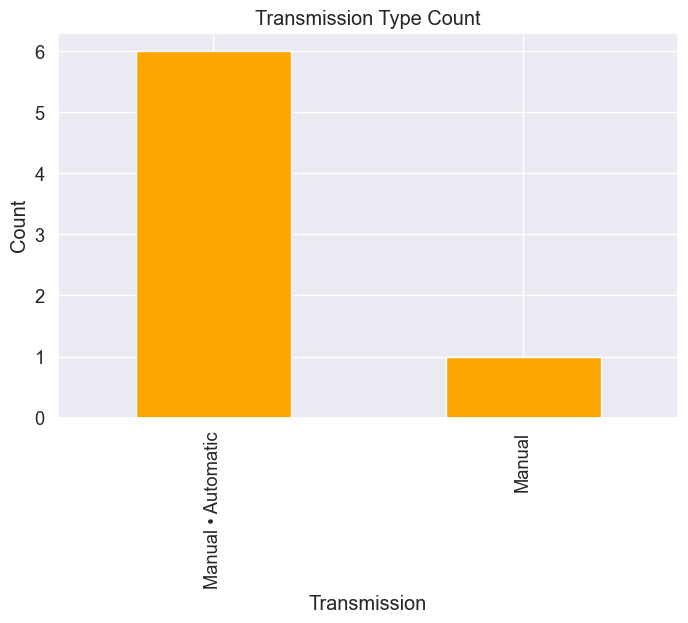

In [27]:
plt.figure(figsize=(8,5))
df['transmission'].value_counts().plot(kind='bar', color='orange')
plt.title("Transmission Type Count")
plt.xlabel("Transmission")
plt.ylabel("Count")
plt.show()

In [36]:
import re

def convert_price(x):
    if pd.isna(x): return np.nan
    s = str(x).lower()
    s = s.replace("₹","").replace(",","").strip()

    if "lakh" in s or "lac" in s:
        num = re.findall(r"[\d\.]+", s)
        return float(num[0]) * 100000 if num else np.nan
    
    if "cr" in s:
        num = re.findall(r"[\d\.]+", s)
        return float(num[0]) * 10000000 if num else np.nan

    num = re.findall(r"[\d\.]+", s)
    return float(num[0]) if num else np.nan

# Create safe numeric columns
if price_cols:
    df["price_num"] = df[price_cols[0]].apply(convert_price)

if km_cols:
    df["km_num"] = pd.to_numeric(df[km_cols[0]].astype(str).str.replace(",",""), errors="ignore")

if year_cols:
    df["year_num"] = pd.to_numeric(df[year_cols[0]], errors="coerce")

df.head()


,brand,model,variants,fuel,transmission,price_range_raw,is_discontinued,detail_url,scrape_date,price_min_lakh,price_max_lakh,price_num
0,Honda,Honda City,N/A,Hybrid • Petrol Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-city/,2025-12-07,None,None,NaN
1,Honda,Honda Elevate,N/A,Petrol • Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-elevate/,2025-12-07,None,None,NaN
2,Honda,Honda Amaze,N/A,Petrol Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-amaze/,2025-12-07,None,None,NaN
3,Honda,Honda Amaze (2021-2024),N/A,Petrol Manual • Automatic,Manual • Automatic,N/A,False,https://ackodrive.com/cars/honda-amaze-2021-2024/,2025-12-07,None,None,NaN
4,Honda,Honda WR-V (2020-2023),N/A,Petrol • Diesel Manual,Manual,N/A,False,https://ackodrive.com/cars/honda-wr-v-2020-2023/,2025-12-07,None,None,NaN


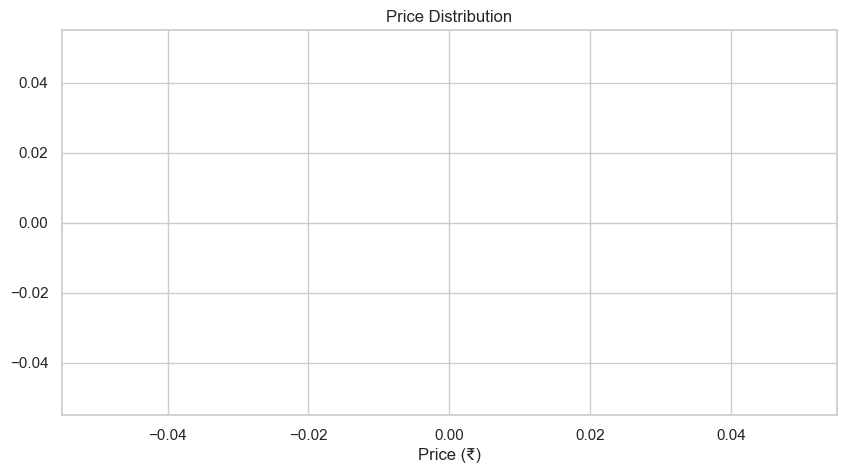

In [48]:
if "price_num" in df:
    sns.histplot(df["price_num"].dropna(), kde=True)
    plt.title("Price Distribution")
    plt.xlabel("Price (₹)")
    plt.show()
else:
    print("Price column not found. Skipping price plot.")


In [45]:
if "price_num" in df and "km_num" in df:
    plt.scatter(df["km_num"], df["price_num"], alpha=0.6)
    plt.title("Price vs Kilometers Driven")
    plt.xlabel("Kilometers")
    plt.ylabel("Price")
    plt.show()


In [46]:
if "price_num" in df and "year_num" in df:
    plt.scatter(df["year_num"], df["price_num"], alpha=0.6)
    plt.title("Price vs Manufacturing Year")
    plt.xlabel("Year")
    plt.ylabel("Price")
    plt.show()

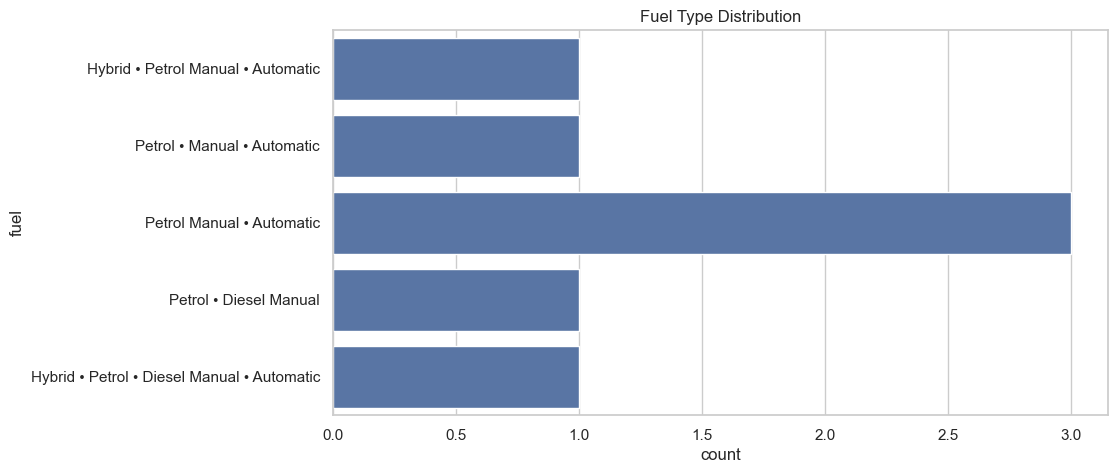

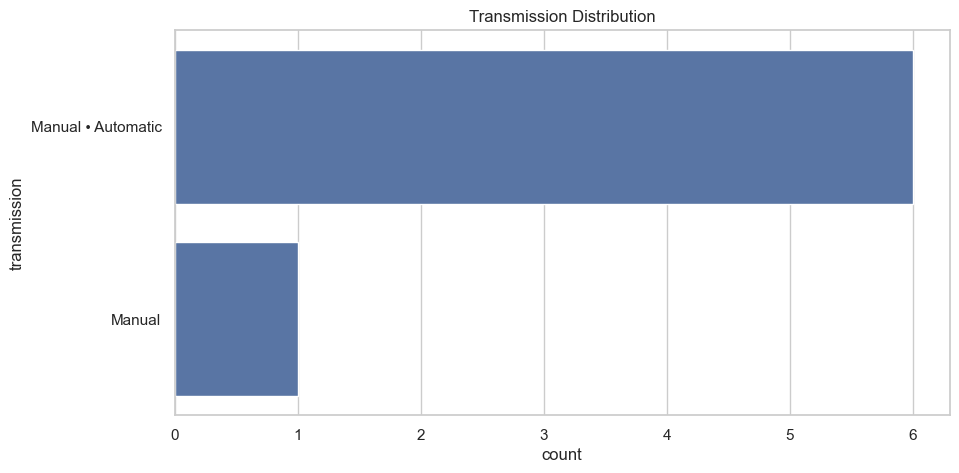

In [47]:
if fuel_col:
    sns.countplot(y=df[fuel_col])
    plt.title("Fuel Type Distribution")
    plt.show()

if trans_col:
    sns.countplot(y=df[trans_col])
    plt.title("Transmission Distribution")
    plt.show()